In [1]:
import h5py
import os,sys,pdb,time
import numpy as np
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
keras.backend.clear_session()  # For easy reset of Jupyter notebook


In [2]:
############################################################
# Data: Load a subset of MNIST data
# split in into train and test
############################################################
# Load hdf5 file in 'r' mode
f = h5py.File('mnist_testdata.hdf5', 'r') # small dataset, assume this our full data
print('keys of the dataset: ', list(f.keys())) # useful for seeing the data set name/key
data = f['xdata'][:]
labels = f['ydata'][:]
print(data.shape, data.dtype, labels.shape, labels.dtype)
data,labels = shuffle(data, labels)

# preprocess the data
data = data/255
print(data.shape, data.dtype)

# spliting training and testing samples
split=7000
x_train = data[:split, ...]
x_test = data[split:,...]
y_train = labels[:split,...]
y_test = labels[split:,...]
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

keys of the dataset:  ['xdata', 'ydata']
(10000, 784) uint8 (10000, 10) float64
(10000, 784) float64
7000 train samples
3000 test samples


In [3]:
############################################################
# Define a functional API model
# Layer 1:                  784 * 64
# Activation 1:             relu
# Layer 2:                  64 * 32
# Activation 1:             relu
# Layer 3:                  32 * 10
# Activation 2:             softmax
############################################################

inputs = keras.Input(shape=(784,))

# a layer instance is callable on a tensor, and returns a tensor
h0 = keras.layers.Dense(64, activation='relu')(inputs)
h1 = keras.layers.Dense(32, activation='relu')(h0)
outputs = keras.layers.Dense(10, activation='softmax')(h1)

# This creates a model that includes
# the Input layer and three Dense layers
model = keras.Model(inputs=inputs, outputs=outputs)

############################################################
# Model printing
############################################################
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 52,650
Trainable params: 52,650
Non-trainable params: 0
_________________________________________________________________
None


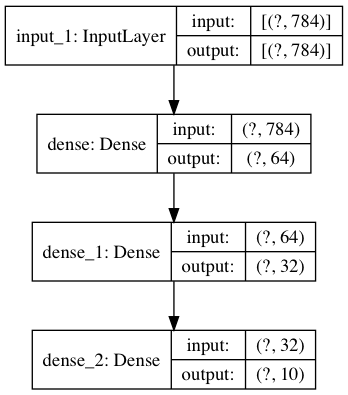

In [4]:
# this will produce a digram of the model -- requires pydot and graphviz installed (pip install pydot graphviz)
# may need to update graphviz package first (Mac: brew install graphviz/Linux: sudo apt-get install graphviz)
keras.utils.plot_model(model, to_file='model_2.png', show_shapes=True, show_layer_names=True)

In [5]:
############################################################
# Model compilation
# Must be called before starting training
############################################################
# For a multi-class classification problem
model.compile(optimizer='sgd',
              loss='categorical_crossentropy', # categorical_crossentropy expects label to be one-hot vector
              metrics=['accuracy'])            # while sparse_categorical_crossentropy handles true labels as integers




In [6]:
# Callback object 1
mcp = keras.callbacks.ModelCheckpoint(filepath="models/best_model_2.hdf5", verbose=2 , save_best_only=True)

# Custom Callback
class AccuracyLogger(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        print('Creating a log directory and cleaning files at the beginning of training')
        os.system('mkdir -p logs')
        with open('logs/train_acc.txt', 'w') as f: 
            f.write('')
        with open('logs/val_acc.txt', 'w') as f: 
            f.write('')

    def on_epoch_end(self, epoch, logs={}):
        print('Inside callback: epoch = ', epoch, 'logs = ', logs)
        train_acc = logs['accuracy']
        val_acc = logs['val_accuracy']
        with open('logs/train_acc.txt', 'a') as f: # open in append mode 'a', will clear previous data if use 'w'  
            f.write('Epoch {}: {}\n'.format(epoch, train_acc))
        with open('logs/val_acc.txt', 'a') as f: # open in append mode 'a', will clear previous data if use 'w'  
            f.write('Epoch {}: {}\n'.format(epoch, val_acc))

# Custom Callback object 2        
al = AccuracyLogger()

        
# Fitting the model with data
results = model.fit(x_train, y_train, batch_size=32, epochs=50, validation_split=0.2, callbacks=[mcp, al])
# You can also save the last model
model.save("models/end_model_2.hdf5")

Train on 5600 samples, validate on 1400 samples
Creating a log directory and cleaning files at the beginning of training
Epoch 1/50
4640/5600 [=======================>......] - ETA: 0s - loss: 2.0376 - accuracy: 0.3614
Epoch 00001: val_loss improved from inf to 1.53744, saving model to models/best_model_2.hdf5
Inside callback: epoch =  0 logs =  {'loss': 1.9670565482548306, 'accuracy': 0.40232143, 'val_loss': 1.5374365895135063, 'val_accuracy': 0.6514286}
5600/5600 [==============================] - 1s 113us/sample - loss: 1.9671 - accuracy: 0.4023 - val_loss: 1.5374 - val_accuracy: 0.6514
Epoch 2/50
5056/5600 [==========================>...] - ETA: 0s - loss: 1.1723 - accuracy: 0.7427
Epoch 00002: val_loss improved from 1.53744 to 0.85893, saving model to models/best_model_2.hdf5
Inside callback: epoch =  1 logs =  {'loss': 1.1447052465166365, 'accuracy': 0.7491071, 'val_loss': 0.8589323803356715, 'val_accuracy': 0.79642856}
5600/5600 [==============================] - 0s 53us/sample 

Epoch 18/50
5024/5600 [=========================>....] - ETA: 0s - loss: 0.2294 - accuracy: 0.9363
Epoch 00018: val_loss improved from 0.28261 to 0.27480, saving model to models/best_model_2.hdf5
Inside callback: epoch =  17 logs =  {'loss': 0.22666797501700264, 'accuracy': 0.9375, 'val_loss': 0.27479556390217375, 'val_accuracy': 0.9235714}
5600/5600 [==============================] - 0s 52us/sample - loss: 0.2267 - accuracy: 0.9375 - val_loss: 0.2748 - val_accuracy: 0.9236
Epoch 19/50
4672/5600 [========================>.....] - ETA: 0s - loss: 0.2182 - accuracy: 0.9396
Epoch 00019: val_loss improved from 0.27480 to 0.27252, saving model to models/best_model_2.hdf5
Inside callback: epoch =  18 logs =  {'loss': 0.21824083445327622, 'accuracy': 0.93964285, 'val_loss': 0.2725210242612021, 'val_accuracy': 0.9257143}
5600/5600 [==============================] - 0s 55us/sample - loss: 0.2182 - accuracy: 0.9396 - val_loss: 0.2725 - val_accuracy: 0.9257
Epoch 20/50
4640/5600 [================

Epoch 36/50
5088/5600 [==========================>...] - ETA: 0s - loss: 0.1372 - accuracy: 0.9615
Epoch 00036: val_loss did not improve from 0.23146
Inside callback: epoch =  35 logs =  {'loss': 0.1348096028342843, 'accuracy': 0.9621429, 'val_loss': 0.23211371123790742, 'val_accuracy': 0.93357146}
5600/5600 [==============================] - 0s 68us/sample - loss: 0.1348 - accuracy: 0.9621 - val_loss: 0.2321 - val_accuracy: 0.9336
Epoch 37/50
5376/5600 [===========================>..] - ETA: 0s - loss: 0.1324 - accuracy: 0.9628
Epoch 00037: val_loss did not improve from 0.23146
Inside callback: epoch =  36 logs =  {'loss': 0.13171822258936508, 'accuracy': 0.9632143, 'val_loss': 0.23272760357175554, 'val_accuracy': 0.93214285}
5600/5600 [==============================] - 0s 65us/sample - loss: 0.1317 - accuracy: 0.9632 - val_loss: 0.2327 - val_accuracy: 0.9321
Epoch 38/50
4896/5600 [=========================>....] - ETA: 0s - loss: 0.1295 - accuracy: 0.9638
Epoch 00038: val_loss did no